### Nama : Alisha Zahra Saadiya
### NIM : 2501971742

Case Number = 4 + 2 = 6

Case 1 : Bidirectual LSTM

In [ ]:
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. a.
Before delving into the data analysis, it is essential to conduct an initial exploration of the dataset to comprehend the challenges inherent within it. The provided dataset is a time series, and it necessitates appropriate preprocessing to resolve any issues that may be present. The time series data should then be divided into two segments: input and output. This division should be structured with a window size of 5 and a horizon of 1, effectively setting up the framework for subsequent analysis.

## Data Exploration

In [ ]:
data = pd.read_csv("X.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-29,432.588074,436.787964,407.388763,432.588074,304.904572,76180670.0
1,2005-09-30,457.787384,457.787384,432.588074,457.787384,322.666016,105493978.0
2,2005-10-03,470.387024,474.586914,440.987854,470.387024,331.546692,59712955.0
3,2005-10-04,474.586914,482.986694,466.187164,474.586914,334.506927,56236668.0
4,2005-10-05,482.986694,482.986694,466.187164,482.986694,340.427429,31319315.0


In [ ]:
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [ ]:
dt = data.dropna()
dt.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Preprocessing

In [ ]:
dt['Data'] = pd.to_datetime(dt['Date'])
df = dt.sort_values("Date")
df.set_index('Date', inplace=True)
select = ['Close']
df_select = df[select].copy()
df_select['Close'] = df_select['Close'].astype(float)

scaler = MinMaxScaler()
df_select['Close'] = scaler.fit_transform(df_select[['Close']])

<ipython-input-6-c492045b84c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['Data'] = pd.to_datetime(dt['Date'])


In [ ]:
window_size = 5
horizon = 1

def create_dataset(dataset, window_size, horizon):
    X, Y = [], []
    for i in range(len(dataset) - window_size - horizon + 1):
        a = dataset[i:(i + window_size), 0]
        X.append(a)
        Y.append(dataset[i + window_size : i + window_size + horizon, 0])
    return np.array(X), np.array(Y)


# 1. b.
Separate data into train, validation and test (80:10:10)

In [ ]:
total_samples = len(df_select)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size

In [ ]:
train = df_select[:train_size]
val= df_select[train_size:train_size + val_size]
test = df_select[train_size + val_size:]

In [ ]:
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (3045, 1)
Validation shape: (380, 1)
Test shape: (382, 1)


In [ ]:
print("Train data", train)

Train data                Close
Date                
2005-09-29  0.036812
2005-09-30  0.043184
2005-10-03  0.046370
2005-10-04  0.047432
2005-10-05  0.049556
...              ...
2018-01-23  0.129713
2018-01-24  0.124656
2018-01-25  0.141091
2018-01-26  0.143620
2018-01-29  0.156263

[3045 rows x 1 columns]


In [ ]:
train_np = train.values
val_np = val.values
test_np = test.values

X_train, Y_train = create_dataset(train_np, window_size, horizon)
X_val, Y_val = create_dataset(val_np, window_size, horizon)
X_test, Y_test = create_dataset(test_np, window_size, horizon)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 1. c
 Create base architecture based on Table 1 (Bidirectional LSTM)

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='relu'), input_shape = (window_size, 1)))

model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))

model.add(Bidirectional(LSTM(units=32, activation='relu')))

model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 256)            133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 128)            164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338753 (1.29 MB)
Trainable params: 338753 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
history = model.fit(X_train,
              Y_train,
              epochs = 20,
              batch_size = 5,
              validation_data = (X_val, Y_val))

Epoch 1/20
608/608 [==============================] - 37s 39ms/step - loss: 0.0030 - val_loss: 9.4751e-05
Epoch 2/20
608/608 [==============================] - 13s 21ms/step - loss: 5.0185e-04 - val_loss: 6.0168e-05
Epoch 3/20
608/608 [==============================] - 13s 21ms/step - loss: 5.4234e-04 - val_loss: 6.9140e-05
Epoch 4/20
608/608 [==============================] - 13s 21ms/step - loss: 4.4561e-04 - val_loss: 6.1248e-05
Epoch 5/20
608/608 [==============================] - 13s 21ms/step - loss: 4.8009e-04 - val_loss: 6.1568e-05
Epoch 6/20
608/608 [==============================] - 13s 22ms/step - loss: 4.2294e-04 - val_loss: 6.9116e-05
Epoch 7/20
608/608 [==============================] - 13s 22ms/step - loss: 3.5831e-04 - val_loss: 9.9826e-05
Epoch 8/20
608/608 [==============================] - 13s 21ms/step - loss: 4.3878e-04 - val_loss: 5.4328e-05
Epoch 9/20
608/608 [==============================] - 13s 22ms/step - loss: 4.0010e-04 - val_loss: 1.7183e-04
Epoch 10/20
60

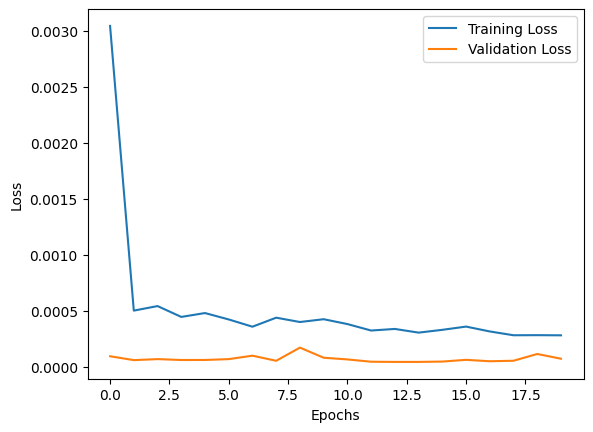

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 1. d
 Adding Sequential Self-Attention Mechanism and explain how the sequential self-attention mechanism works.


In [ ]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=837deb56f7e366779eddcee427fa236d56c0b2b4e3a4ca6f33177e99eb7890c6
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention

In [ ]:
model2 = Sequential()

model2.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='relu'), input_shape = (window_size, 1)))

model2.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))

model2.add(SeqSelfAttention(attention_activation='relu'))

model2.add(Bidirectional(LSTM(units=32,  activation='relu')))

model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 5, 256)            133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 5, 128)            164352    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 338753 (1.29 MB)
Trainable params: 338753 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
history2 = model2.fit(X_train,
              Y_train,
              epochs = 20,
              batch_size = 5,
              validation_data = (X_val, Y_val))

Epoch 1/20
608/608 [==============================] - 39s 43ms/step - loss: 0.0026 - val_loss: 1.5731e-04
Epoch 2/20
608/608 [==============================] - 13s 22ms/step - loss: 4.7473e-04 - val_loss: 8.6804e-05
Epoch 3/20
608/608 [==============================] - 13s 22ms/step - loss: 5.5012e-04 - val_loss: 1.1032e-04
Epoch 4/20
608/608 [==============================] - 14s 22ms/step - loss: 4.3455e-04 - val_loss: 5.2131e-05
Epoch 5/20
608/608 [==============================] - 14s 22ms/step - loss: 4.7703e-04 - val_loss: 5.6093e-05
Epoch 6/20
608/608 [==============================] - 14s 22ms/step - loss: 4.1008e-04 - val_loss: 6.3354e-05
Epoch 7/20
608/608 [==============================] - 14s 23ms/step - loss: 3.7092e-04 - val_loss: 6.2491e-05
Epoch 8/20
608/608 [==============================] - 13s 22ms/step - loss: 3.6641e-04 - val_loss: 7.1610e-05
Epoch 9/20
608/608 [==============================] - 13s 22ms/step - loss: 3.5340e-04 - val_loss: 9.0144e-05
Epoch 10/20
60

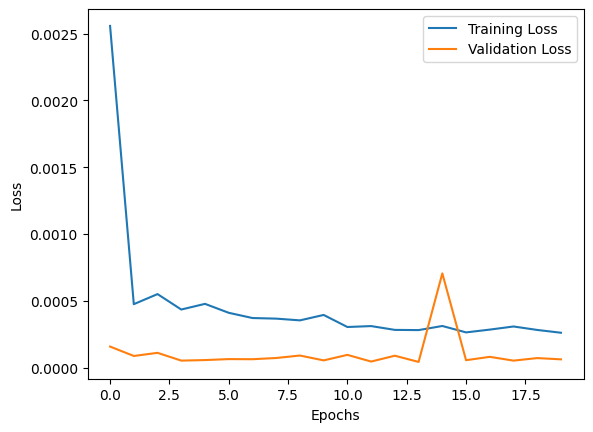

In [ ]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> Mekanisme sequential self-attention bekerja dengan menangkap hubungan antara posisi yang berbeda dalam sebuah sequence untuk menghitung representasi yang lebih baik dari sequence tersebut. Mekanisme ini memungkinkan model untuk menimbang bagian dari sequence untuk kepentingan fitur relatif, sehingga meningkatkan representasi sequence. Dalam Bidirectional LSTM, mekanisme sequential self-attention bekerja dengan memberikan bobot ke bagian yang berbeda dari input sequence berdasarkan relevansinya dengan output saat ini, dengan mempertimbangkan arah maju dan mundur dari sequence tersebut.

> Mekanisme sequential self-attention dalam layer Bidirectional LSTM bekerja dengan memproyeksikan data input menggunakan proyeksi linier yang berbeda yang dipelajari dari data yang sama, dan kemudian menerapkan mekanisme perhatian pada masing-masingnya secara bersamaan. Hal ini menghasilkan matriks berbobot yang menyimpan informasi masa lalu dan masa depan yang lebih relevan secara bersamaan, sehingga memungkinkan model untuk menangkap ketergantungan temporal dalam data dengan lebih baik.


Referensi : Rendón-Segador, F. J., Álvarez-García, J. A., Enríquez, F., & Deniz, O. (2021). Violencenet: Dense multi-head self-attention with bidirectional convolutional lstm for detecting violence. Electronics, 10(13), 1601. Diakses dari : https://www.mdpi.com/2079-9292/10/13/1601



# 1. e
Please proceed to evaluate the architecture outlined above on the test set, utilizing evaluation metrics that are congruent with the architecture specified in number 1c and 1d. Include a justification for the choice of these evaluation metrics. Subsequently, provide a detailed explanation of the results obtained.

In [ ]:
y_pred = model.predict(X_test)

12/12 [==============================] - 1s 11ms/step


In [ ]:
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print("Base Bidirectional LMST Model Metrics:")
print("Mean Squared Error (MSE) :", mse)
print("Mean Absolute Error (MAE) :", mae)
print("R-squared (R2) :", r2)

Base Bidirectional LMST Model Metrics:
Mean Squared Error (MSE) : 0.00040419744048652396
Mean Absolute Error (MAE) : 0.011607738632101029
R-squared (R2) : 0.9767733362162128


In [ ]:
y_pred2 = model2.predict(X_test)

12/12 [==============================] - 1s 13ms/step


In [ ]:
mse2 = mean_squared_error(Y_test, y_pred2)
mae2 = mean_absolute_error(Y_test, y_pred2)
r2_2 = r2_score(Y_test, y_pred2)

print("\nBidirectional LMST Model with Sequential Self-Attention Metrics:")
print("Mean Squared Error (MSE):", mse2)
print("Mean Absolute Error (MAE):", mae2)
print("R-squared (R2):", r2_2)


Bidirectional LMST Model with Sequential Self-Attention Metrics:
Mean Squared Error (MSE): 0.0003752046532463506
Mean Absolute Error (MAE): 0.011341864155866953
R-squared (R2): 0.9784393678481098


Metriks evaluasi model pada data *time series* yang sering digunakan yaitu MSE, MAE, dan R2.
- *Mean Square Error* merupakan rata-rata dari selisih kuadrat antara nilai prediksi dengan nilai aktual. MSE digunakan untuk mengukur seberapa besar rata-rata kesalahan prediksi dari nilai aktual. Semakin rendah hasil MSE maka semakin baik model dengan prediksinya
- *Mean Absolute Error* merupakan nilai rata-rata perbedaan antara nilai aktual dengan nilai prediksi model. MAE digunakan untuk mengukur keakuratan suatu model dalam melakukan prediksi. Hasil MAE yang kecil menunjukkan bahwa model baik dalam prediksi, sedangkan hasil MAE yang besar menunjukkan model mengalami masalah dalam memprediksi
- R-squared merupakan ukuran statistik yang menunjukkan seberapa besar variasi suatu variabel dependen dapat dijelaskan oleh variabel independen dalam suatu model. R2 biasanya digunakan untuk mengidentifikasi akurasi pada model. Jika R2 mendekati nilai 1 maka semakin baik modelnya. Namun, jika R2 sama dengan 0, maka model tidak berkinerja dengan baik.

Berdasarkan hasil evaluasi metriks diatas dapat disimpulkan bahwa model 1d atau model bidirectional LSTM yang menggunakan sequential self-attention lebih baik daripada model bidirectional LSTM biasa.

Referensi : Faiqoh, H. Penerapan Ensemble Feature Selection Untuk Mengurangi Dimensionalitas dalam Prediksi data Time Series (Bachelor's thesis, Fakultas Sains dan Teknologi UIN Syarif Hidayatullah Jakarta). Diakses dari : https://repository.uinjkt.ac.id/dspace/handle/123456789/67099

# 1. f
Create a line chart that displays a comparison between the prediction results from models 1d and 1c, and the actual values

In [ ]:
# Predictions from model1 (1c)
predictions_model = model.predict(X_test)

# Predictions from model2 (1d)
predictions_model2 = model2.predict(X_test)

# Actual values
actual_values = Y_test

print("Shapes - Actual Values:", actual_values.shape, "Predictions Model 1:", predictions_model.shape, "Predictions Model 2:", predictions_model2.shape)


12/12 [==============================] - 0s 11ms/step
Shapes - Actual Values: (377, 1) Predictions Model 1: (377, 1) Predictions Model 2: (377, 1)


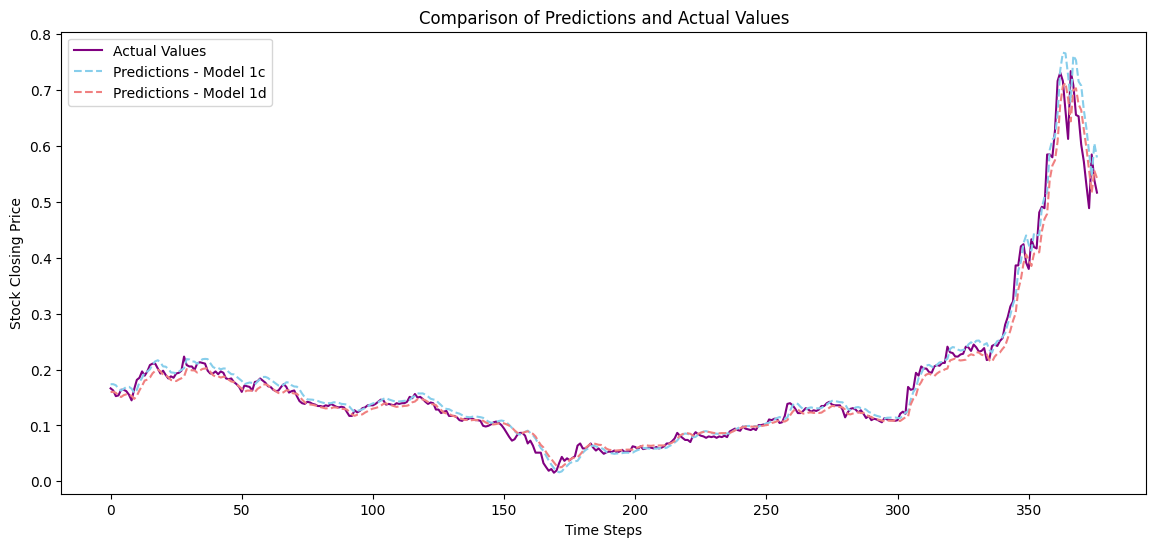

In [ ]:
predictions_model_flat = predictions_model.flatten()
predictions_model2_flat = predictions_model2.flatten()

plt.figure(figsize=(14, 6))

plt.plot(actual_values, label='Actual Values', color='purple')

# Plotting predictions from model (1c)
plt.plot(predictions_model_flat, label='Predictions - Model 1c', color='skyblue', linestyle='--')

# Plotting predictions from model2 (1d)
plt.plot(predictions_model2_flat, label='Predictions - Model 1d', color='lightcoral', linestyle='--')

plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Stock Closing Price')
plt.legend()
plt.show()

Berdasarkan hasil grafik diatas dapat diketahui bahwa kedua model telah memprediksi dengan tepat hampir semua nilai target sebenarnya (actual value). Namun, model pada 1c di akhir grafik sedikit menjauhi nilai sebenarnya (actual value).